In [1]:
import pandas as pd
import numpy as np
import datetime
import lmfit
from lmfit.models import ExpressionModel
import matplotlib.pyplot as plt

In [2]:
# generalized sigmoid function
def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x - b)))

In [3]:
# derivative of generalized sigmoid function
def dsigmoid(x, a, b, c):
    return a * c * np.exp(-a * (x - b)) / (1 + np.exp(-a * (x - b))) / (1 + np.exp(-a * (x - b)))

In [4]:
# read John Hopkins data from Github
base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

# deaths_global = pd.read_csv(base_url + 'time_series_covid19_deaths_global.csv')
deaths_us = pd.read_csv(base_url + 'time_series_covid19_deaths_US.csv')

# get latest or current date from data set(s)
latest_date = deaths_us.columns.values[-1]

# aggregate data by state (separate highest and lowest states)
us_drop_columns = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key']
deaths_us.drop(us_drop_columns + ['Population'], axis=1, inplace=True)
deaths_us_sorted = deaths_us.groupby('Province_State').agg('sum').sort_values(by=latest_date, ascending=False)

# only consider states with deaths greater than 50
us_deaths = deaths_us_sorted[deaths_us_sorted[latest_date] > 50].T
states = us_deaths.columns.values
# print(states)

In [5]:
# set x axis numpy arrays
num_days = us_deaths.shape[0]
xdata = np.linspace(0, num_days - 1, num_days)  # x data for curve fit
xtest = np.linspace(0, 99, 100)  # x data for plot and peak

base = datetime.datetime(2020, 1, 22)
arr = np.array([base + datetime.timedelta(days=i) for i in range(100)])  # x data as dates for plots

New York 0.2758
State:  New York  has fixed a parameter...


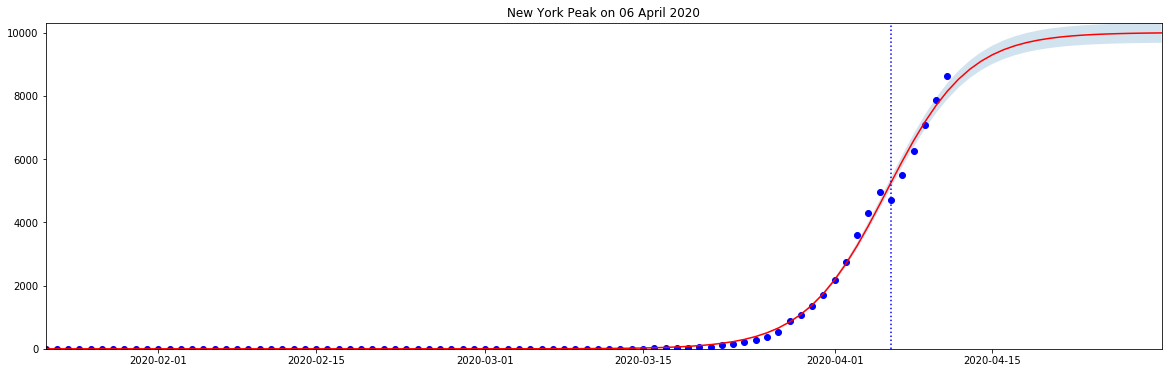

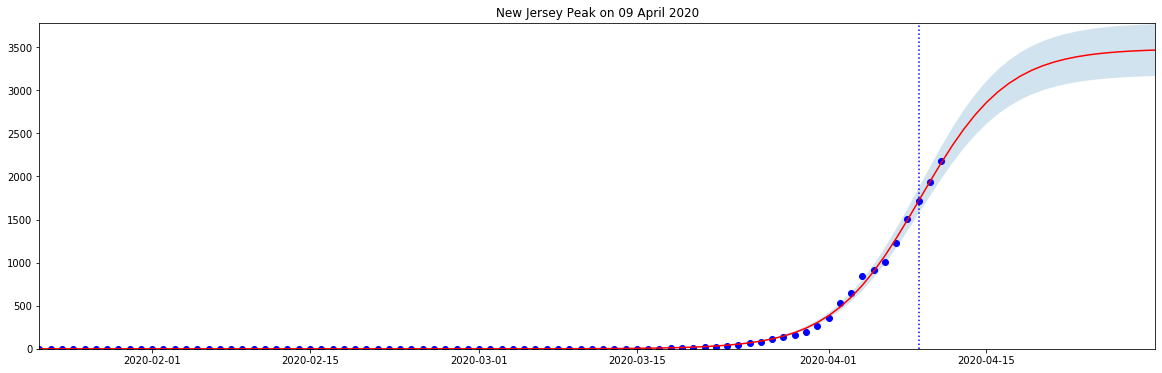

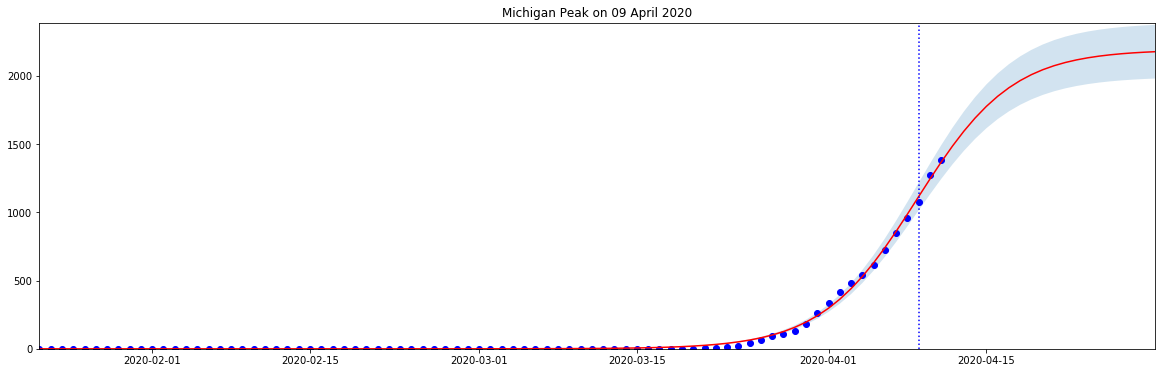

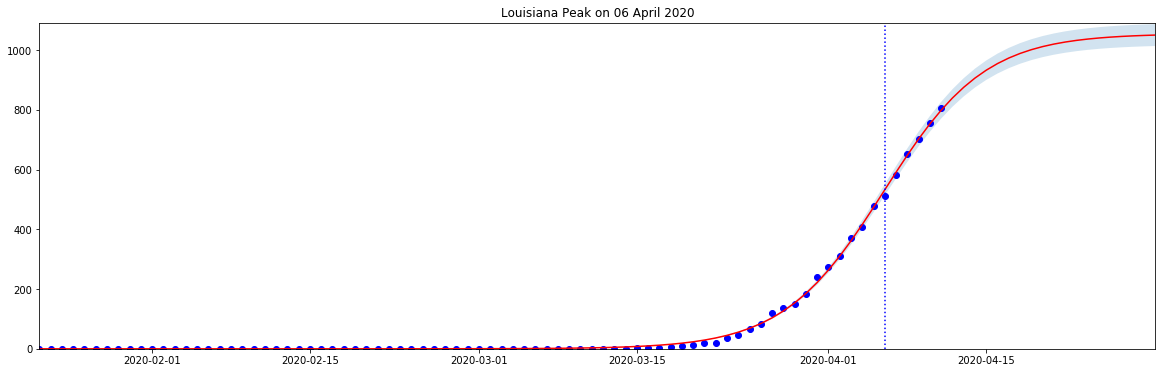

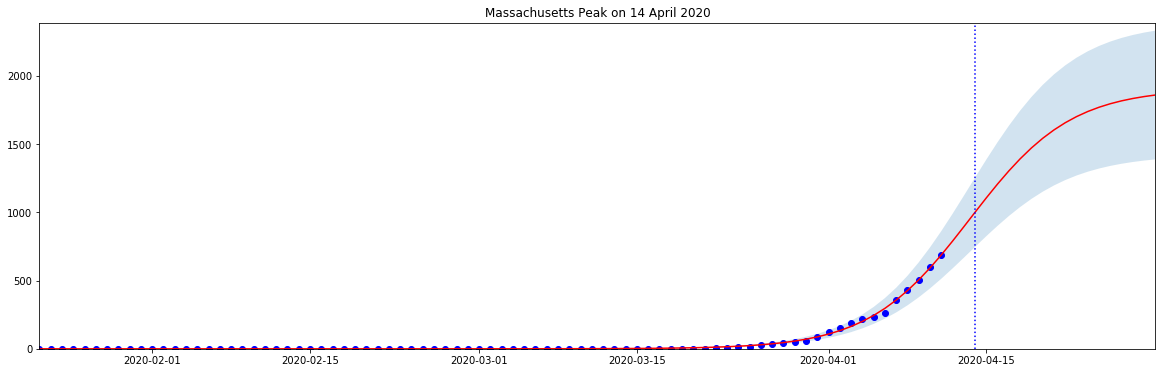

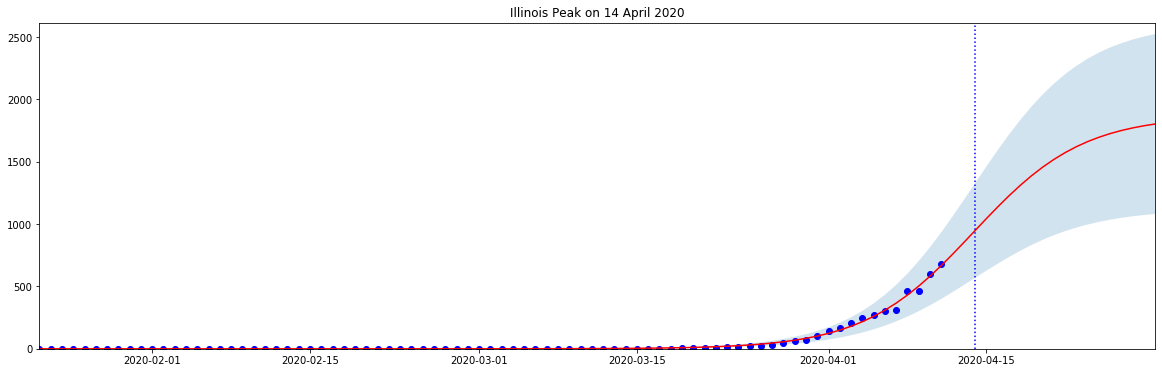

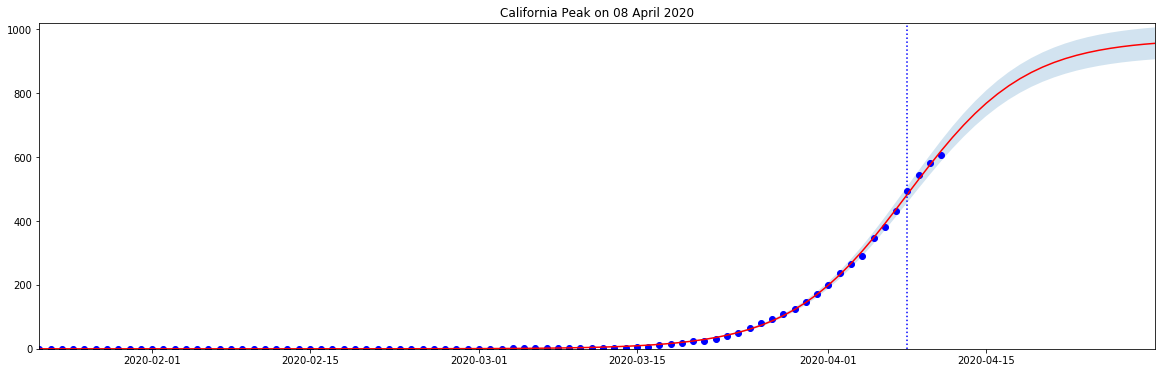

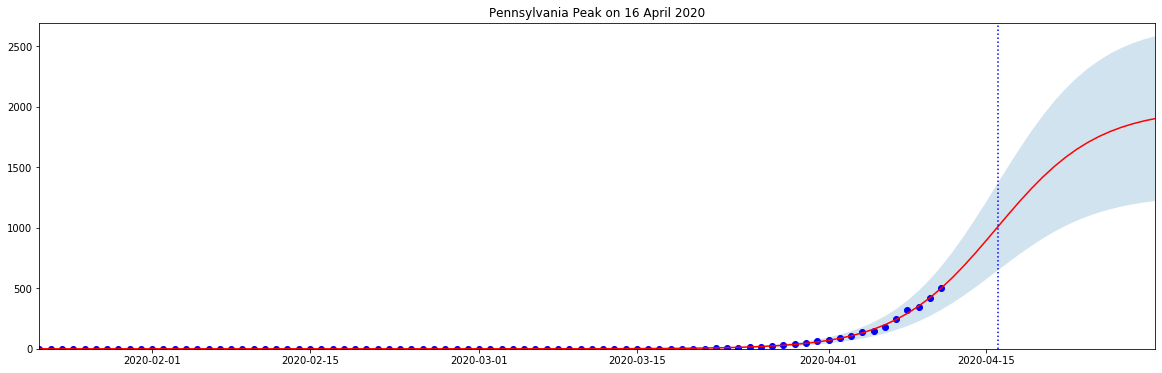

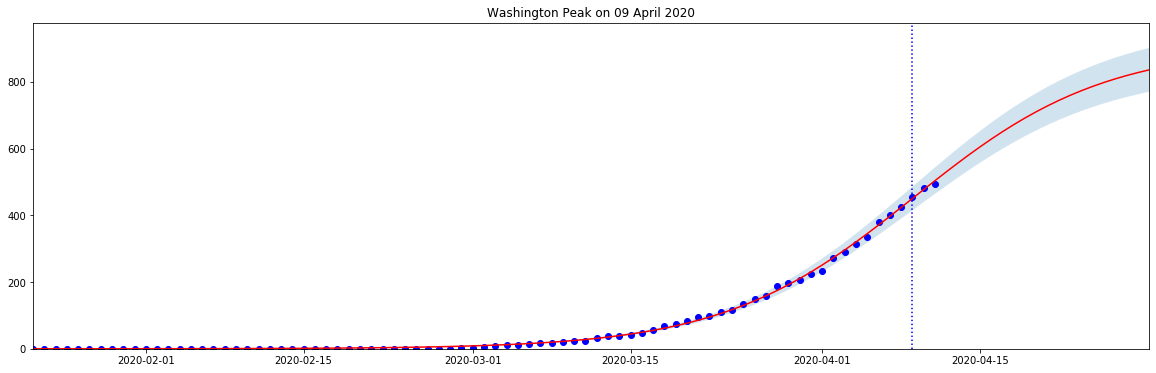

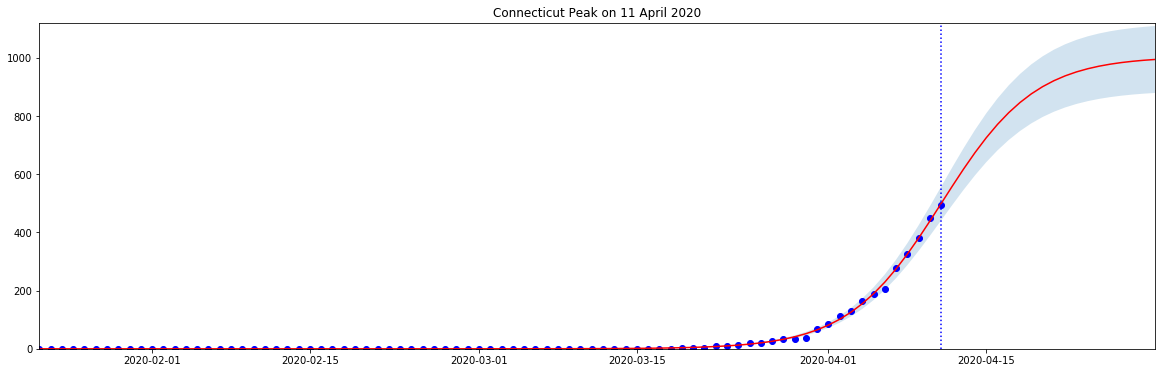

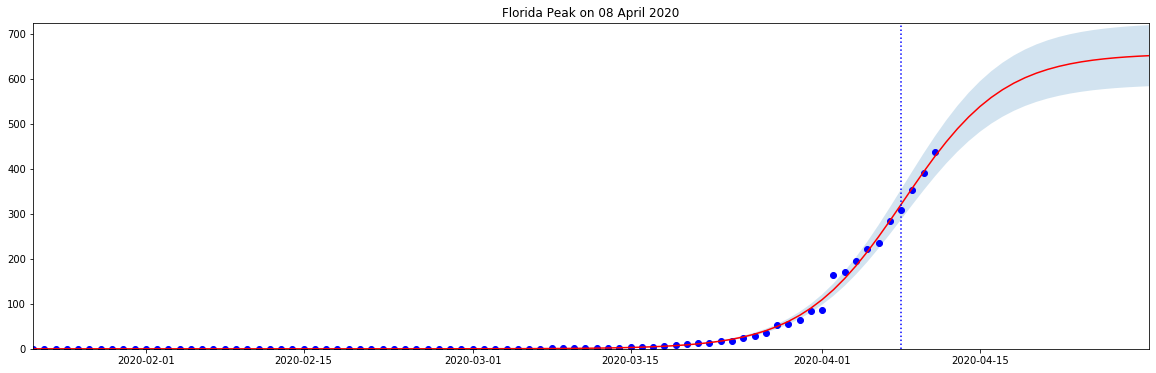

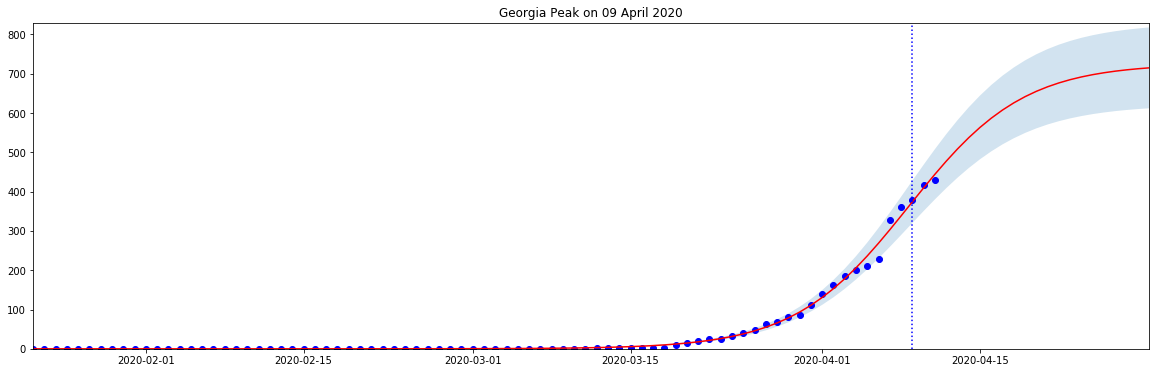

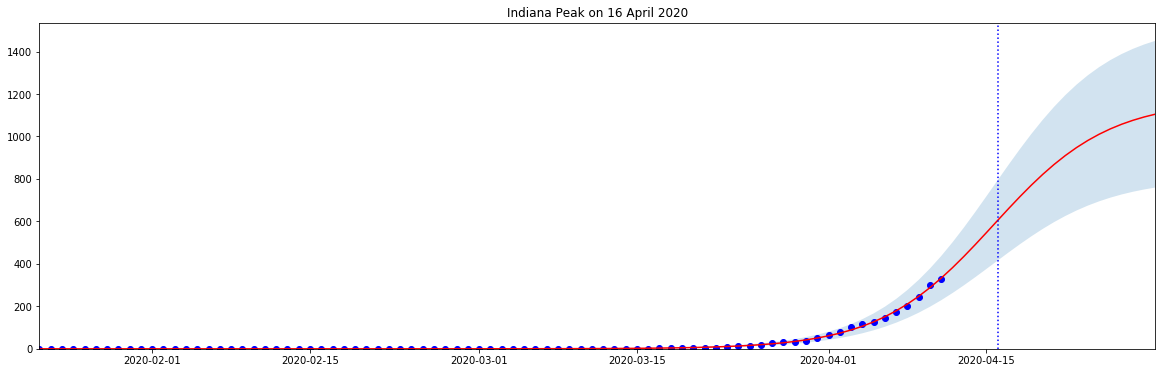

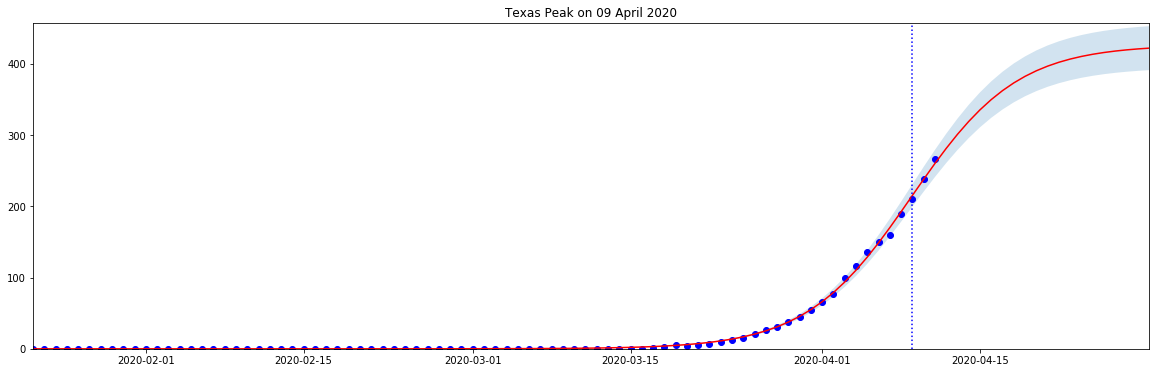

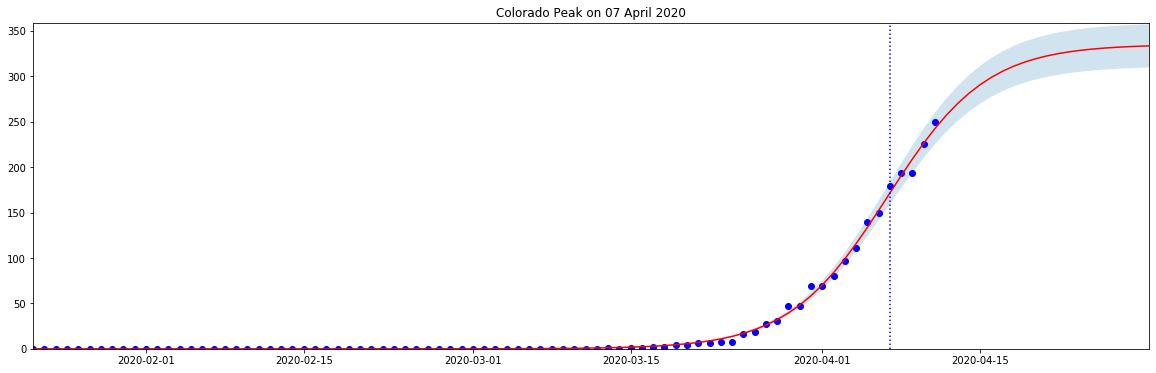

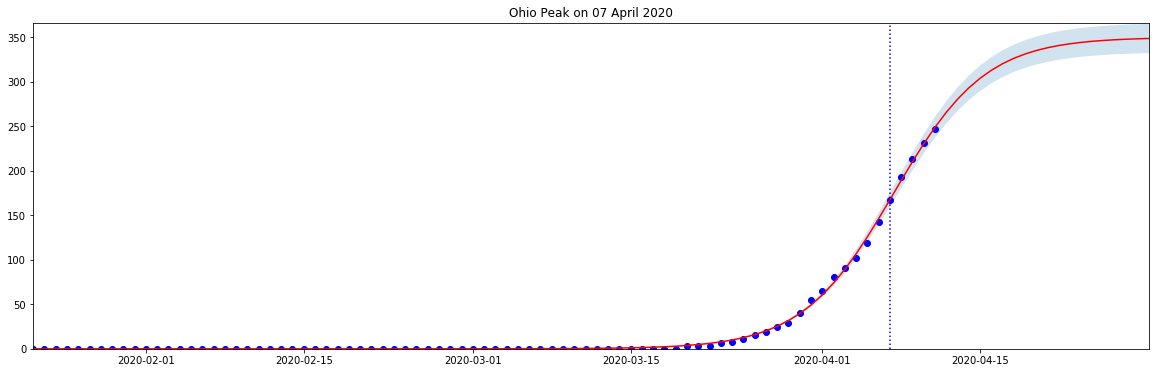

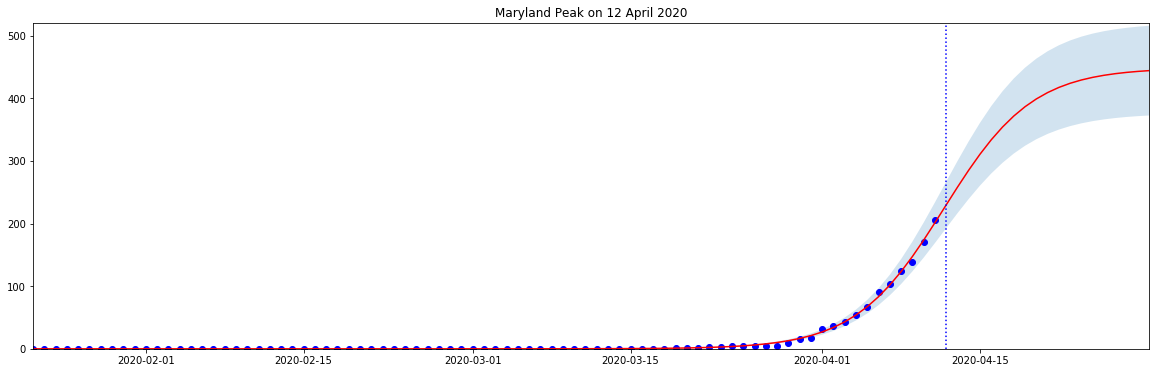

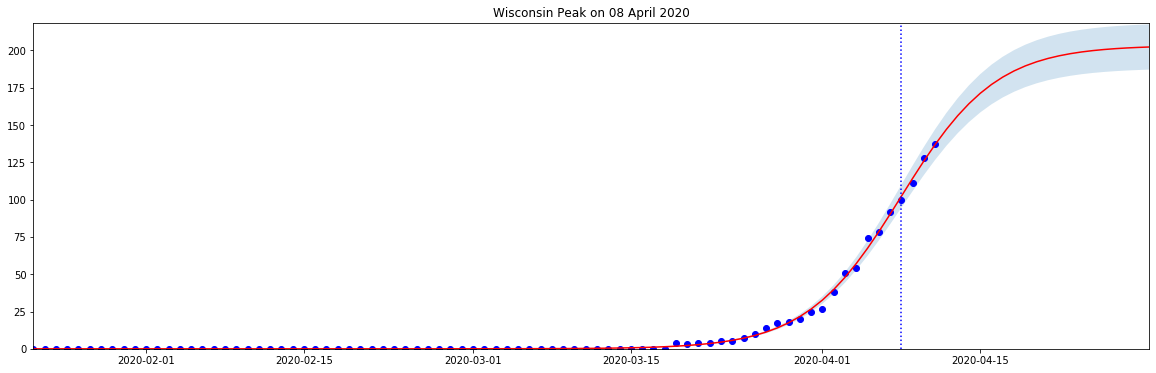

State:  Virginia  has fixed a parameter...


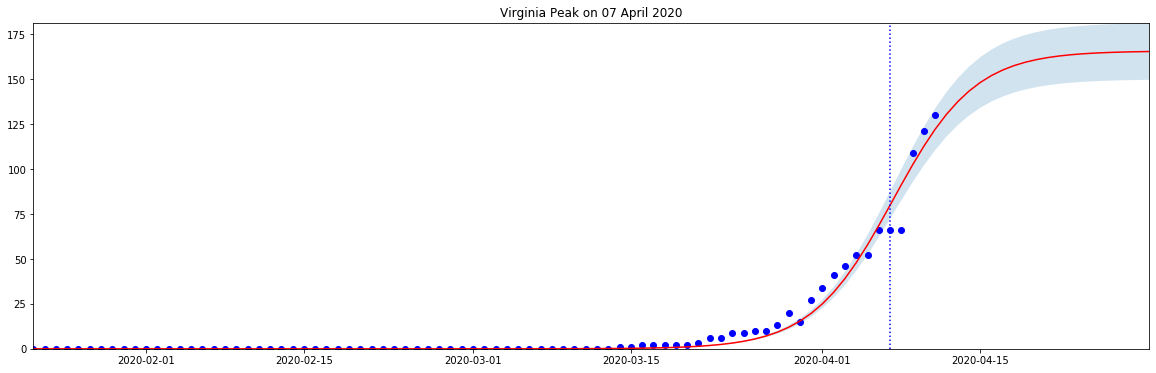

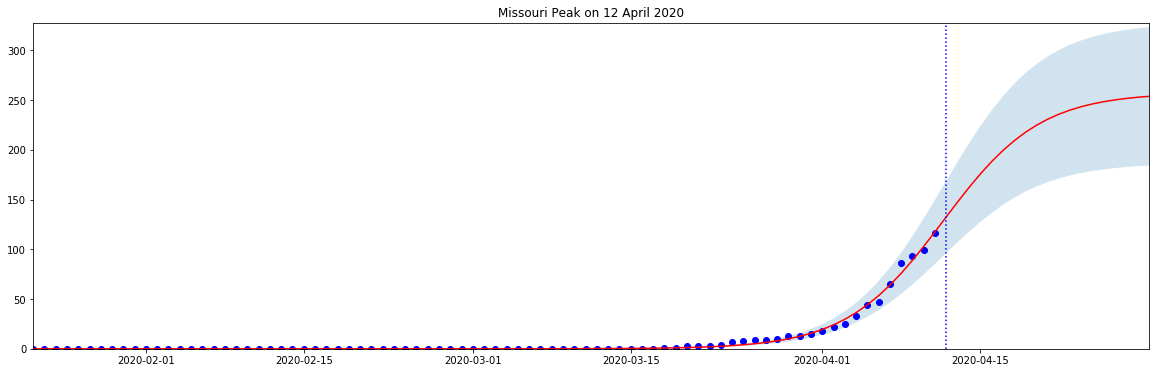

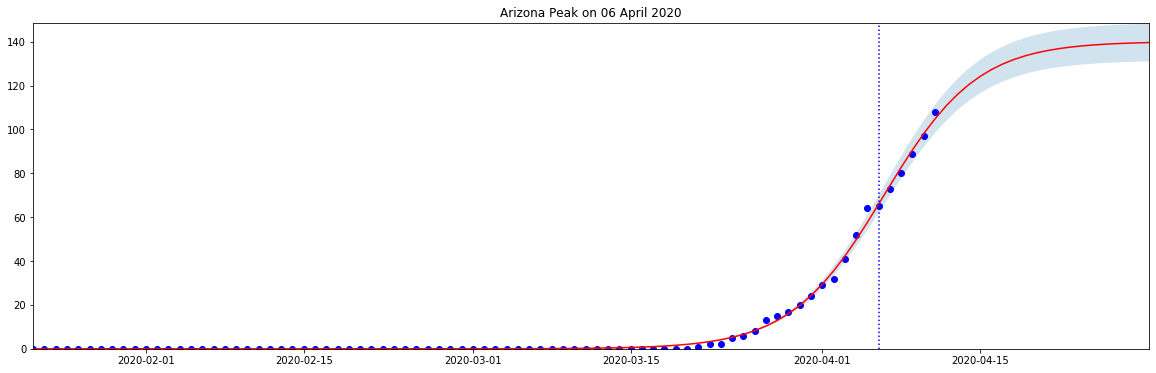

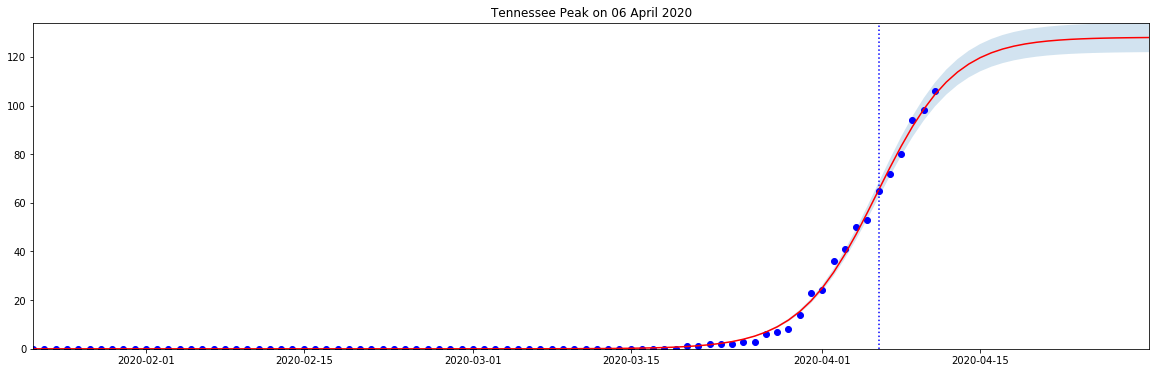

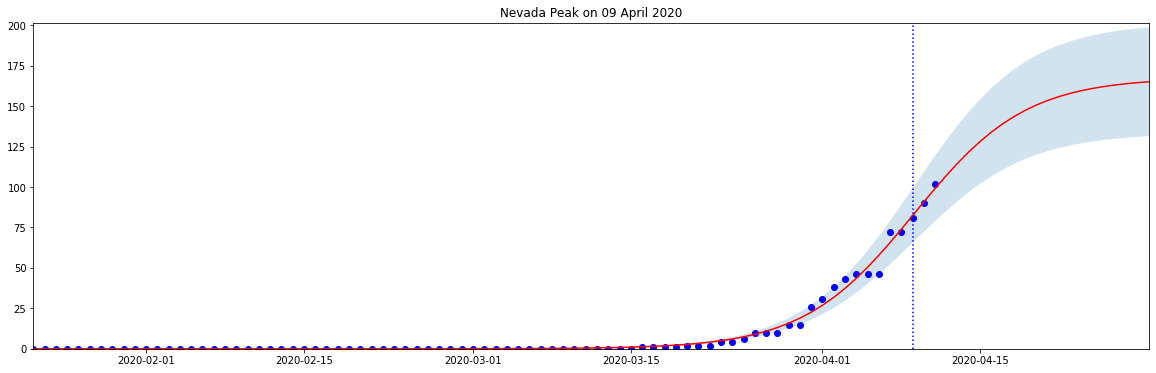

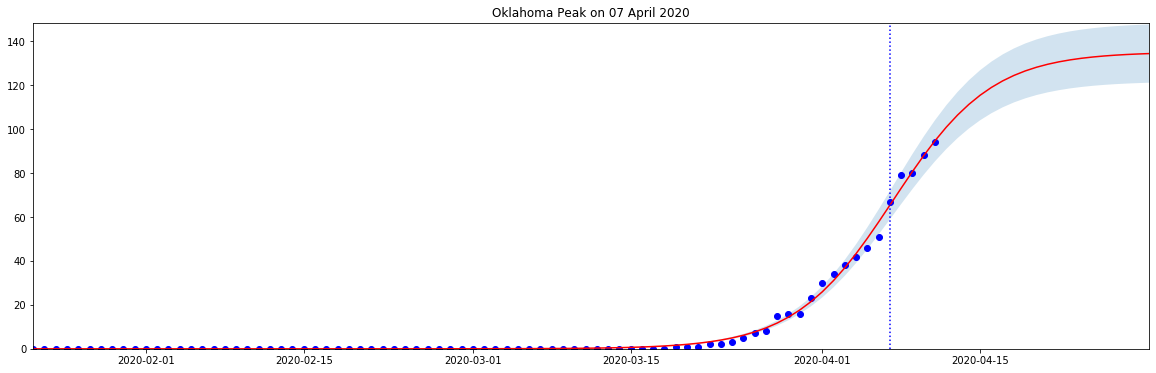

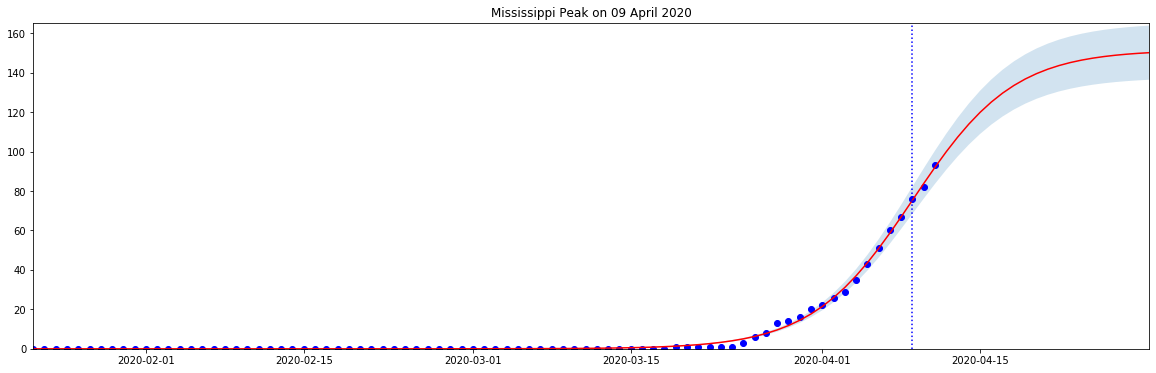

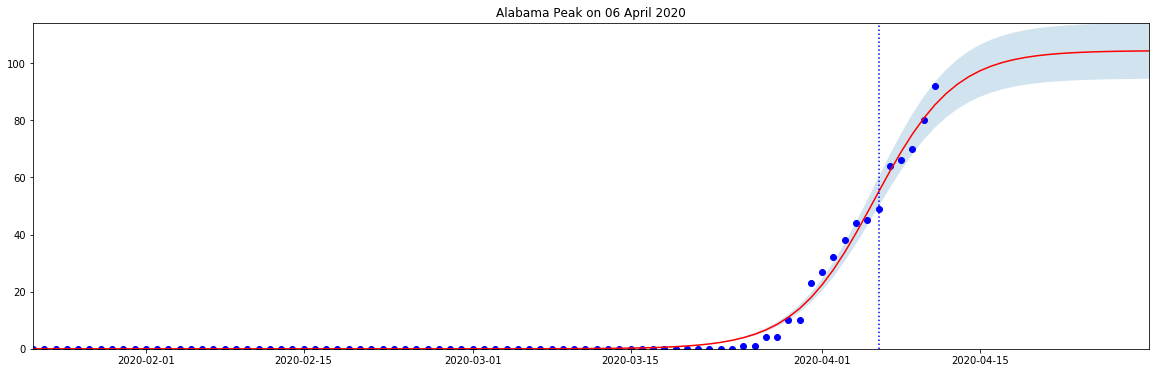

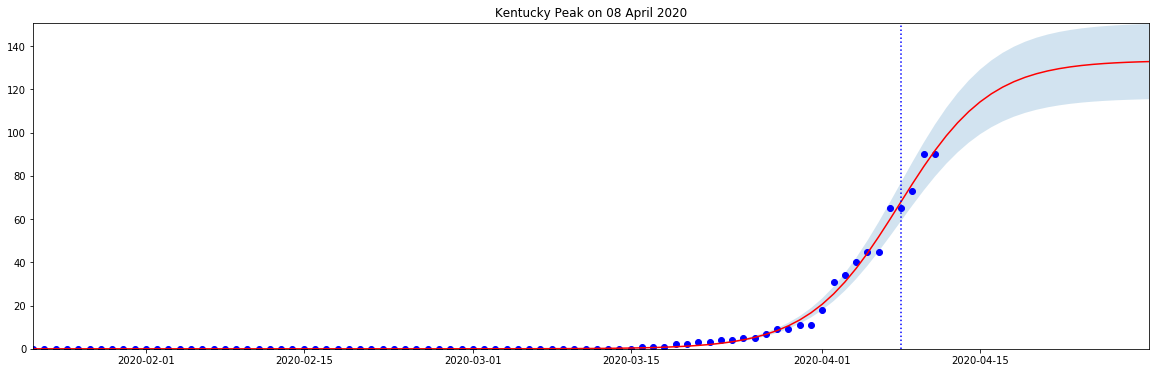

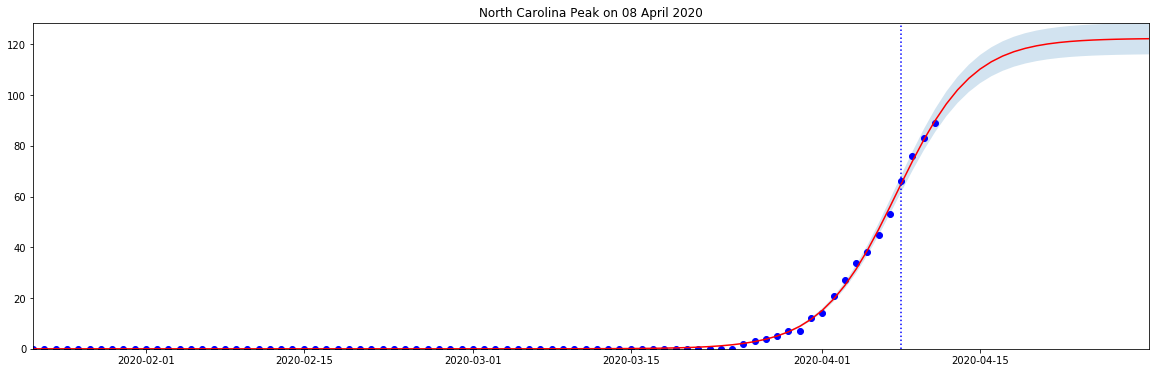

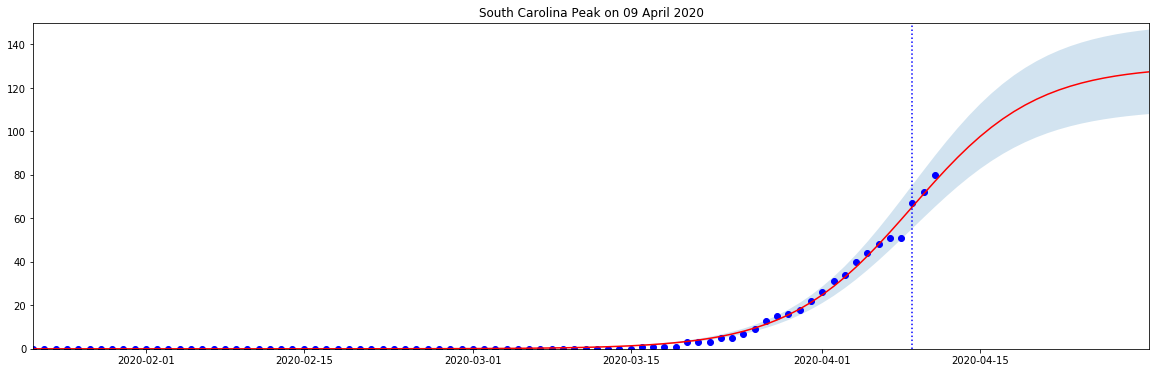

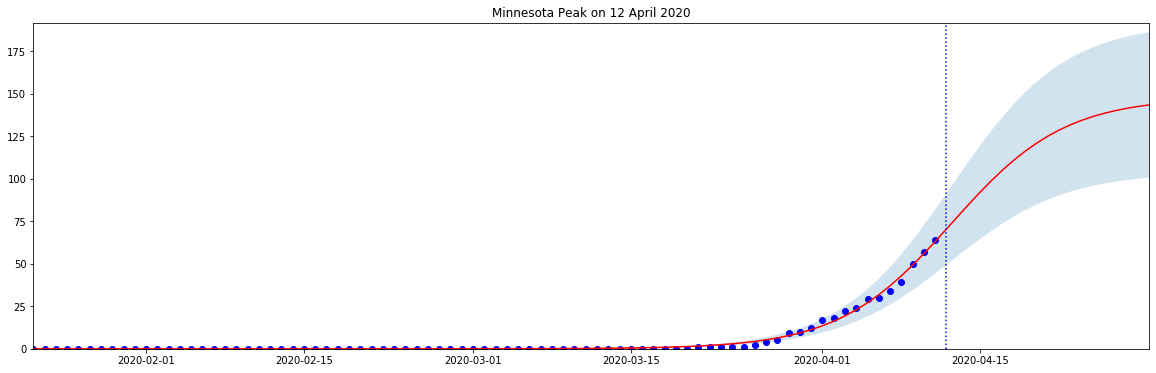

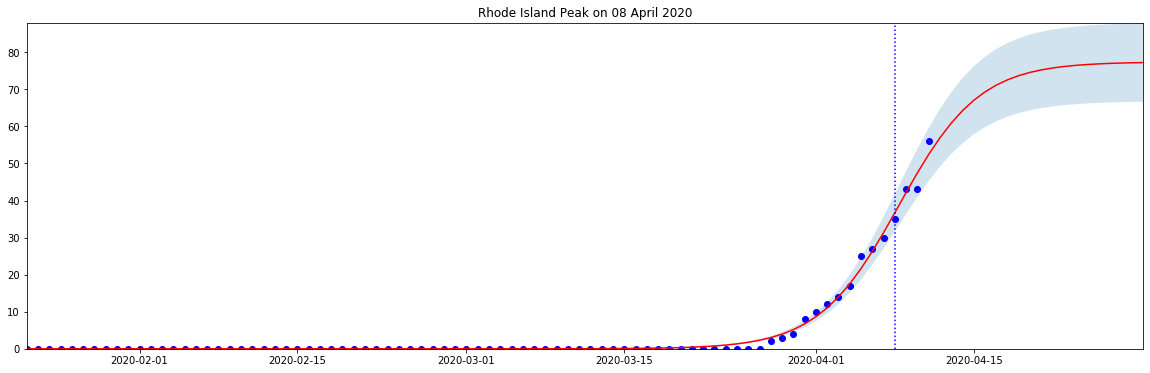

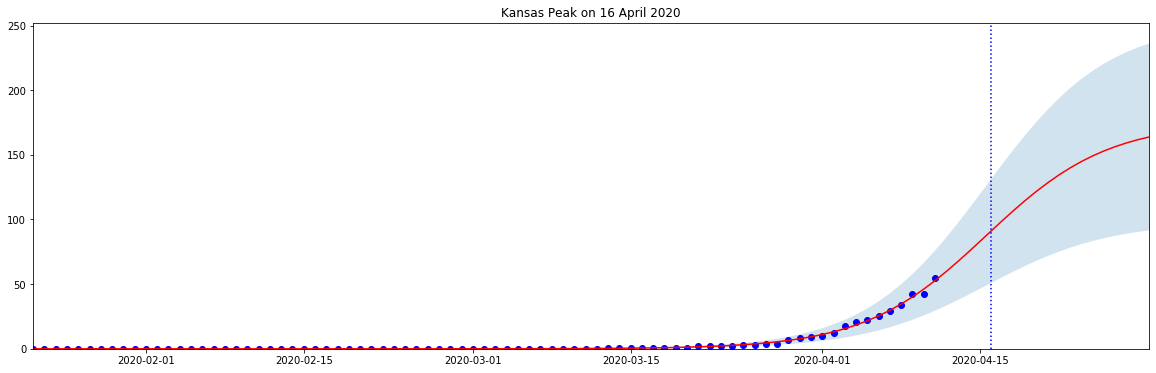

In [6]:
adef = 0
predicted_total = 0
err_total = 0

total = None
lower = None
upper = None
dtotal = None
dlower = None
dupper = None

for state in states:
    # define lmfit model
    model = ExpressionModel('c / (1 + exp(-a * (x - b)))')
    params = lmfit.Parameters()
    params.add('a', value=0.3, min=0.0, max=0.5)
    params.add('b', value=40.0, min=10.0, max=100.0)
    params.add('c', value=1.0, min=0.0, max=10000.0)

    ydata = us_deaths[state].values
    # print(state)
    results = model.fit(ydata, params, x=xdata)
    a = results.params['a'].value
    # if state is New York, save 'a' parameter if needed to constrain other fits (with one less parameter)
    if state == 'New York':
        print('New York', '{:.4f}'.format(results.params['a'].value))
        adef = '{:.4f}'.format(results.params['a'].value)

    # if model does not fit (c --> inf), then constrain with fixed 'a' parameter
    if results.params['c'].value > 9900 or results.params['c'].stderr > results.params['c'].value:
        a = float(adef)
        print("State: ", state, " has fixed a parameter...")
        model = ExpressionModel('c / (1 + exp(-' + adef + ' * (x - b)))')
        params = lmfit.Parameters()
        params.add('b', value=40.0, min=10.0, max=100.0)
        params.add('c', value=1.0, min=0.0, max=10000.0)
        results = model.fit(ydata, params, x=xdata)

    # print(results.fit_report(min_correl=0.25))
    b = results.params['b'].value
    c = results.params['c'].value
    # confidence band (95%)
    conf = 1.96 * results.params['c'].stderr

    predicted_total += results.params['c'].value
    err_total += results.params['c'].stderr
    # print(state)
    # for key in results.params:
    #    print(key, "=", results.params[key].value, "+/-", results.params[key].stderr)

    fig = plt.figure(figsize=(20, 6))
    # plt.plot(xdata, ydata, 'bo')
    # plt.plot(xdata, results.best_fit, 'r-')
    plt.plot(arr[0: len(ydata)], ydata, 'bo')
    actual = sigmoid(xtest, a, b, c)
    actual_lower = sigmoid(xtest, a, b, c - conf)
    actual_upper = sigmoid(xtest, a, b, c + conf)
    plt.plot(arr, actual, 'r-')
    plt.fill_between(arr, actual_lower, actual_upper, alpha=0.2)
    plt.xlim(arr[0], arr[-1])
    plt.ylim(0, c + conf)
    max_idx = np.argmax(dsigmoid(xtest, a, b, c))
    plt.plot([arr[max_idx], arr[max_idx]], [0.0, c + conf], linestyle=':', color='b')
    plt.title("{} Peak on {}".format(state, arr[max_idx].strftime('%d %B %Y')))
    plt.show()

    # add to total and total confidence bands
    if total is None:
        total = actual
        lower = actual_lower
        upper = actual_upper
        dtotal = dsigmoid(xtest, a, b, c)
        dlower = dsigmoid(xtest, a, b, c - conf)
        dupper = dsigmoid(xtest, a, b, c + conf)
    else:
        total = np.add(total, actual)
        lower = np.add(lower, actual_lower)
        upper = np.add(upper, actual_upper)
        dtotal = np.add(dtotal, dsigmoid(xtest, a, b, c))
        dlower = np.add(dlower, dsigmoid(xtest, a, b, c - conf))
        dupper = np.add(dupper, dsigmoid(xtest, a, b, c + conf))

Current Total: 20457.00
Predicted Total: 31719.67
Confidence Interval: [27644.72, 35794.63]


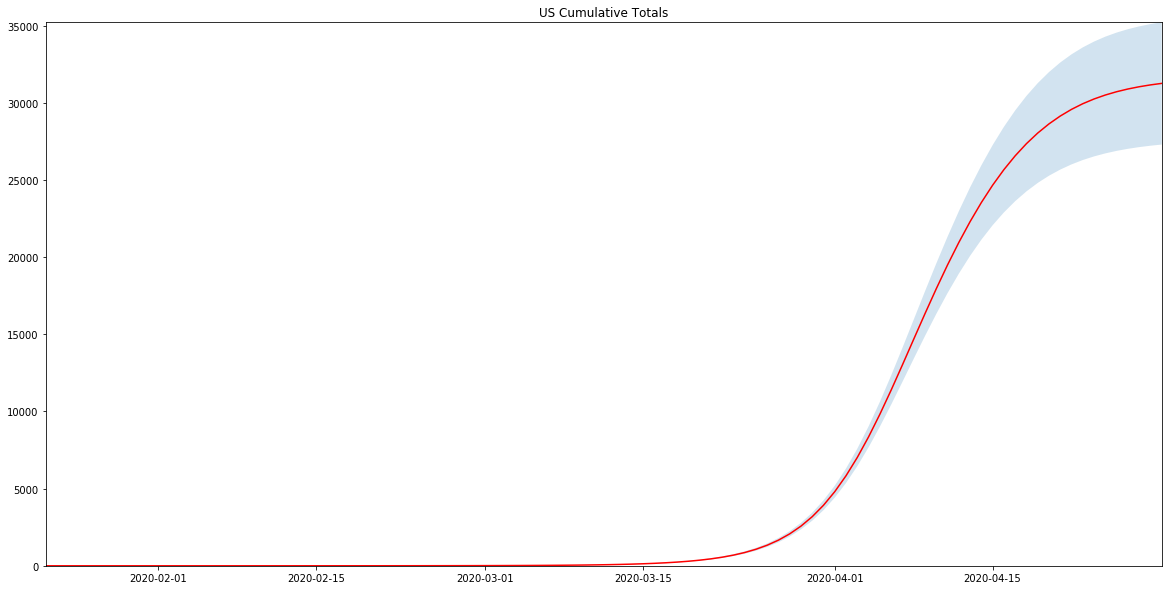

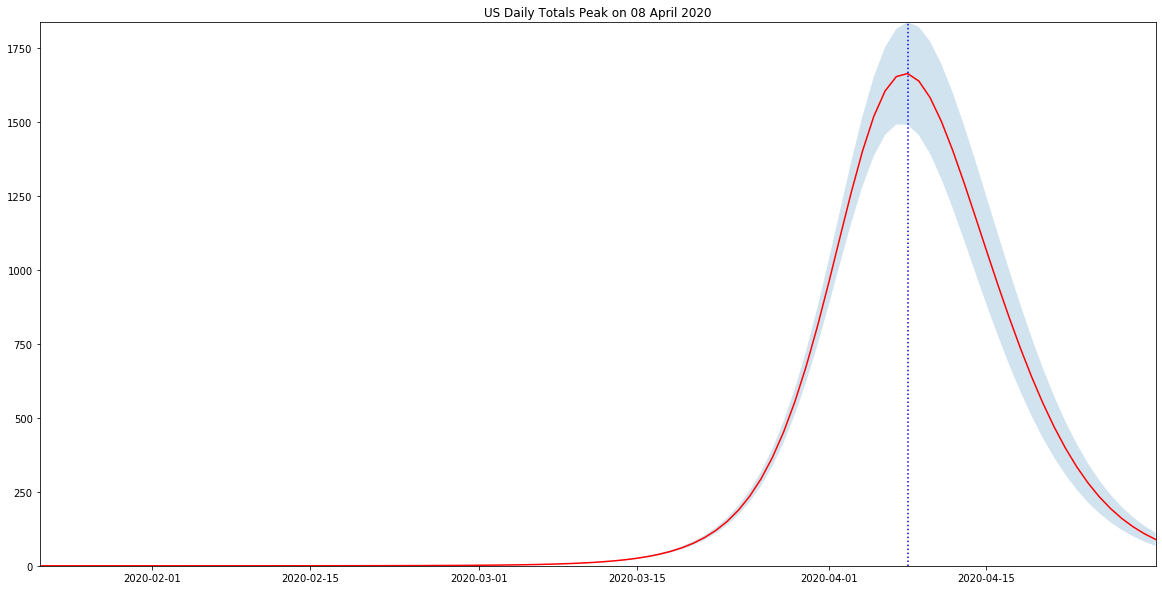

In [7]:
current_total = deaths_us[latest_date].sum()
print("Current Total: {:.2f}".format(current_total))
print("Predicted Total: {:.2f}".format(predicted_total))
print("Confidence Interval: [{:.2f}, {:.2f}]".format(predicted_total - 1.96 * err_total, predicted_total + 1.96 * err_total))

fig = plt.figure(figsize=(20, 10))
plt.plot(arr, total, 'r-')
plt.fill_between(arr, lower, upper, alpha=0.2)
plt.xlim(arr[0], arr[-1])
plt.ylim(0, upper[-1])
plt.title("US Cumulative Totals")
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.plot(arr, dtotal, 'r-')
plt.fill_between(arr, dlower, dupper, alpha=0.2)
plt.xlim(arr[0], arr[-1])
plt.ylim(0, np.max(dupper))
max_idx = np.argmax(dtotal)
plt.plot([arr[max_idx], arr[max_idx]], [0.0, np.max(dupper)], linestyle=':', color='b')
plt.title("US Daily Totals Peak on {}".format(arr[max_idx].strftime('%d %B %Y')))
plt.show()